# 2 Volume measuring and smoothing
In this module, we will develop a program that segments a computed tomography image of the mandible of a goat with a dental implant, and which measures the relative amount of bone in radial strips from the implant.

It is assumed that the student has completed the previous module: GettingStarted. The pedagogical plan is that the student receives the code as a jupyter file, runs each stump, correct possible mistakes, and reflects on the output. Some assignments have been added for the student to test his/her understanding of the material.

The demonstration uses a slice from a synchrotron image of a dental implant in the jaw bone of a goat. The image shows the implant and screw, bone, and cavities. For further details, see Neldam et al., Synchrotron Radiation µCT and histology evaluation of bone-to-implant contact, Journal of Cranio-Maxillo-Facial Surgery, 2017 (accepted for publication)

# 2.1 Preliminaries
First we setup the Python setting including the libraries, that we are going to use.

In [1]:
from skimage import io, morphology, filters, segmentation
import numpy as np
from matplotlib import pyplot as plt, cm
plt.rcParams['image.cmap'] = 'gray' # set default colormap for imshow to be gray

We read and display the image

<class 'numpy.uint16'>


Text(0.5, 1.0, 'CT image')

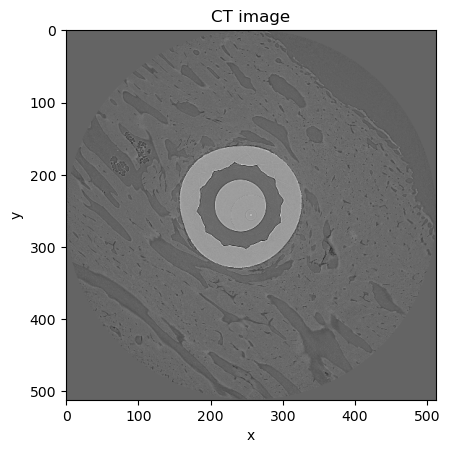

In [2]:
im = io.imread("implant.tiff")
print(type(im[0,0]))
plt.imshow(im)
plt.xlabel('x')
plt.ylabel('y')
plt.title('CT image')

The image contains mainly 3 types of material: implants (light gray), bone (medium gray), cavities (dark gray). We take the simple approach of segmenting the image by thresholding. First we examine the intensity histogram, and then we set thresholds by eyeballing.

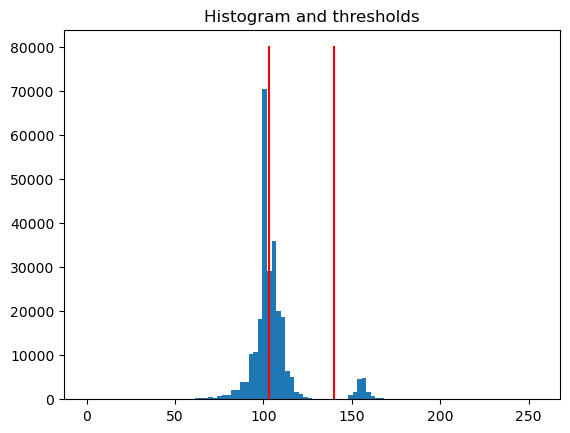

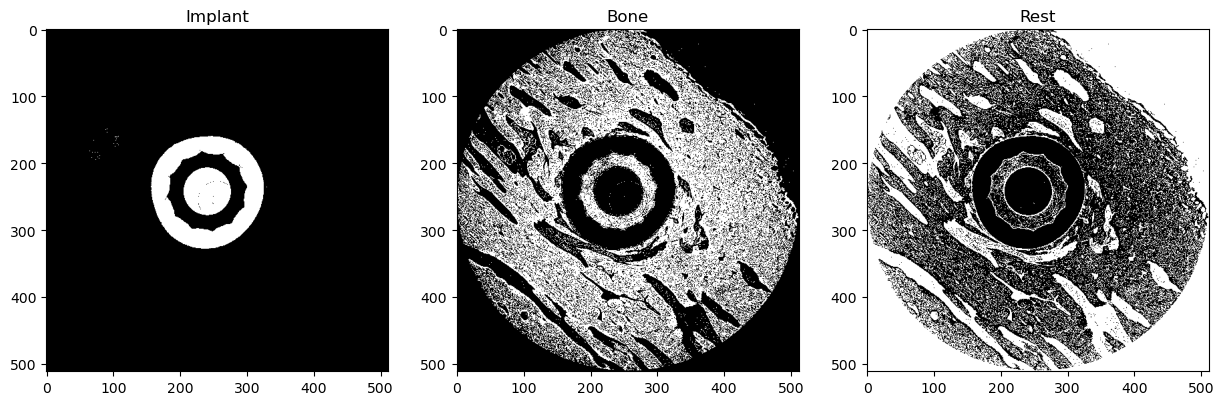

In [3]:
plt.hist(im.flatten(),100)
tBone = 103
tImplt = 140
plt.plot([tBone, tBone], [0, 80000], 'r-')
plt.plot([tImplt, tImplt], [0, 80000], 'r-')
plt.title('Histogram and thresholds')
plt.show()

implt = im > tImplt
bone = np.logical_and(tBone < im, im < tImplt)
rest = np.logical_not(np.logical_or(implt,bone))

fig, ax = plt.subplots(1, 3, figsize=(15,5)) # figsize sets size in inches
ax[0].imshow(implt)
ax[0].set_title('Implant')
ax[1].imshow(bone)
ax[1].set_title('Bone')
ax[2].imshow(rest)
ax[2].set_title('Rest');

The result is fairly close to our expectation but noisy. To get an idea of the noise, we zoom in on a region of the image.

Text(0.5, 1.0, 'Zoom of rest mask')

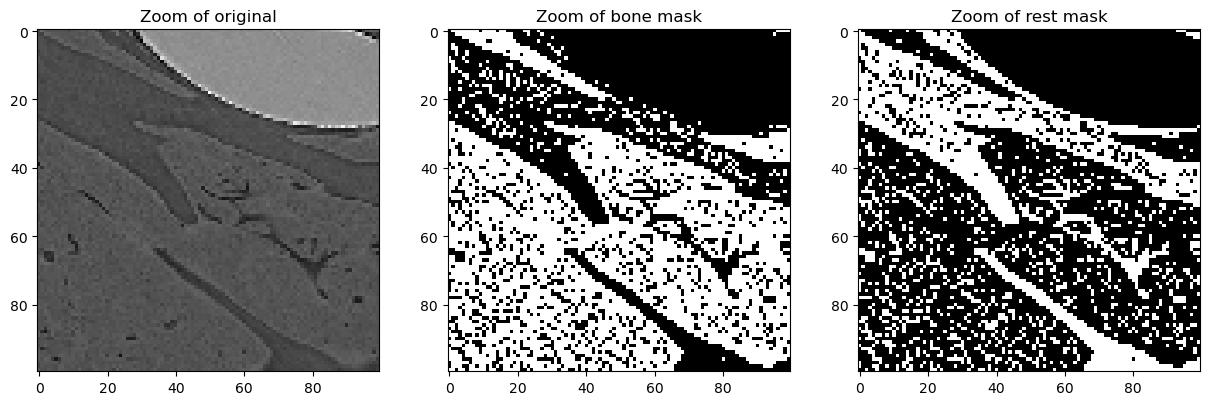

In [4]:
rowFrom, rowTo = 300, 400
colFrom, colTo = 150, 250
fig, ax = plt.subplots(1, 3, figsize=(15,5)) # figsize sets size in inches
ax[0].imshow(im[rowFrom:rowTo,colFrom:colTo])
ax[0].set_title("Zoom of original")
ax[1].imshow(bone[rowFrom:rowTo,colFrom:colTo])
ax[1].set_title("Zoom of bone mask")
ax[2].imshow(rest[rowFrom:rowTo,colFrom:colTo])
ax[2].set_title("Zoom of rest mask")

**Assignment 2a:** Make for loop that plots the result of using a number of different thresholds in order to search for a possibly better separation of bone and cavity.

# 2.2 Noise removal
We see that bone regions have dark pixels and cavity regions have light pixels. We consider this as noise and will apply a noise reducing median filtering before thresholding: Median filtering replaces each pixel value with the median of nearby intensities.

Text(0.5, 1.0, 'Zoom of smoothed rest mask')

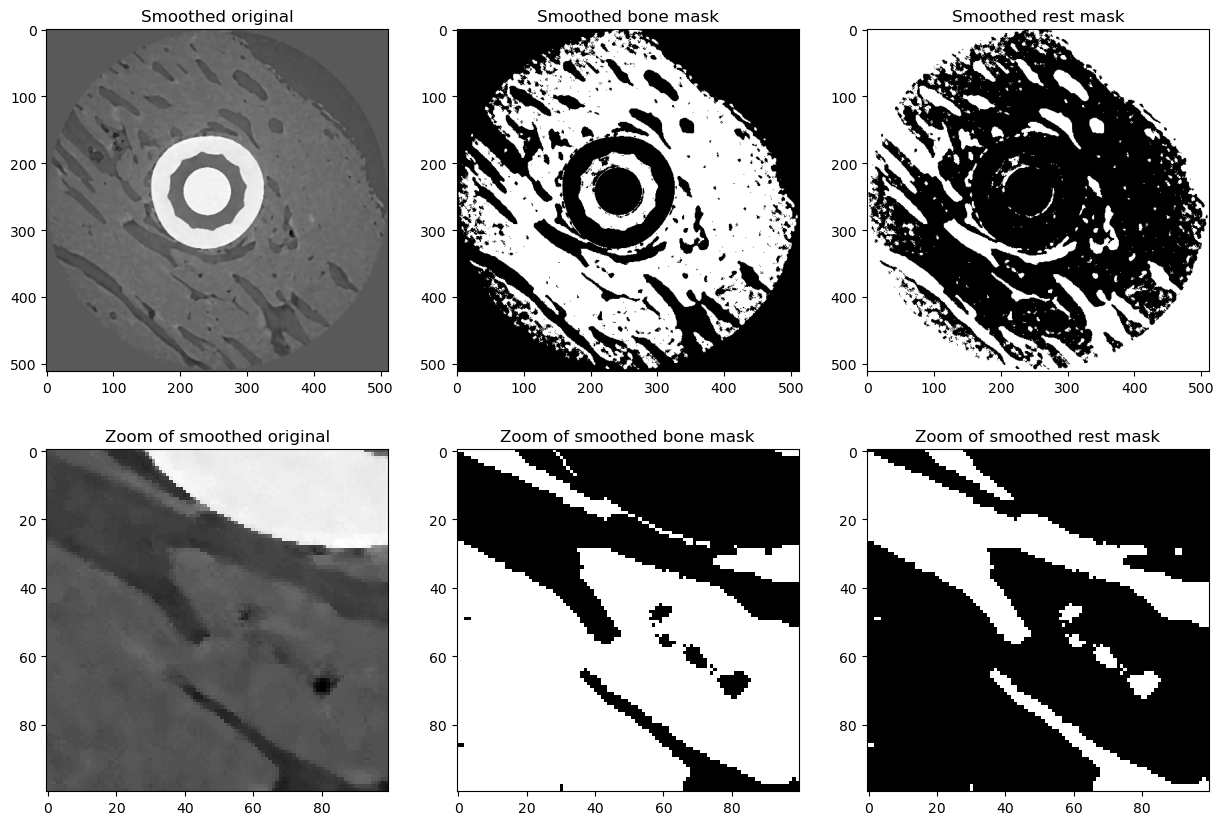

In [5]:
dskelm = morphology.disk(3)
imFilt = filters.median(im, dskelm)
impltFilt = imFilt > tImplt
boneFilt = np.logical_and(tBone < imFilt, imFilt < tImplt)
restFilt = np.logical_not(np.logical_or(impltFilt,boneFilt))

fig, ax = plt.subplots(2, 3, figsize=(15,10)) # figsize sets size in inches
ax[0,0].imshow(imFilt)
ax[0,0].set_title("Smoothed original")
ax[0,1].imshow(boneFilt)
ax[0,1].set_title("Smoothed bone mask")
ax[0,2].imshow(restFilt)
ax[0,2].set_title("Smoothed rest mask")
ax[1,0].imshow(imFilt[rowFrom:rowTo,colFrom:colTo])
ax[1,0].set_title("Zoom of smoothed original")
ax[1,1].imshow(boneFilt[rowFrom:rowTo,colFrom:colTo])
ax[1,1].set_title("Zoom of smoothed bone mask")
ax[1,2].imshow(restFilt[rowFrom:rowTo,colFrom:colTo])
ax[1,2].set_title("Zoom of smoothed rest mask")

The image is now much smoother, and the segments without noise. However, we see that sharp corners have also been reduced. I.e., filtering cannot easily distinquish between noise and small structure.

**Assignment 2b:** Make a for loop for different disk sizes and choose what you think is optimal?

We will now study the image outside the implant. Since our plan is to use dilation, we must first close the hole in the implant. For this we use the concept of convex hull.

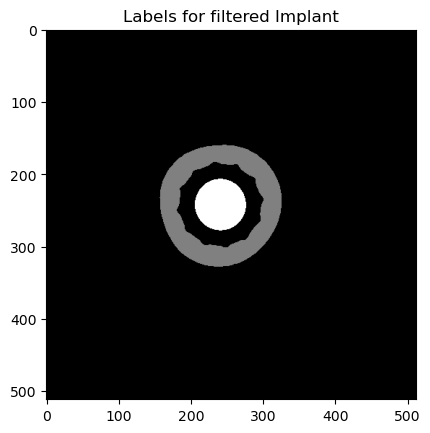

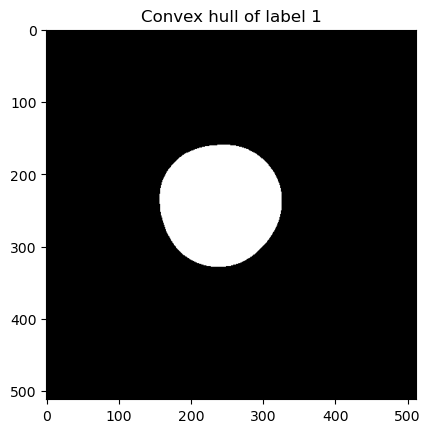

In [6]:
impltFiltLabels = morphology.label(impltFilt)
plt.imshow(impltFiltLabels)
plt.title("Labels for filtered Implant")
plt.show()
hull = morphology.convex_hull_image(impltFiltLabels==1)
plt.imshow(hull)
plt.title("Convex hull of label 1")
plt.show()

Now we use dilation to iteratively expand the implant mask. By keeping the previous mask, we can calculate the difference, hence, a roundish strip. The strip is then used to isolate pixel values in the bone mask and calculate the relative number of pixels per area of the strip. This is then plottet.

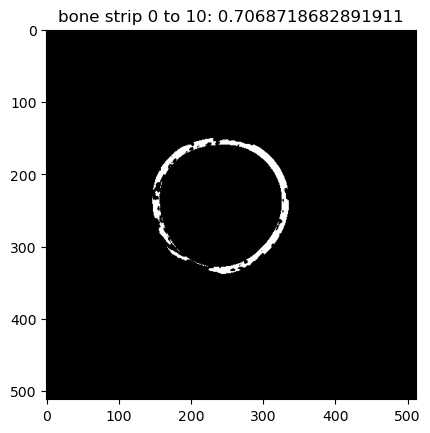

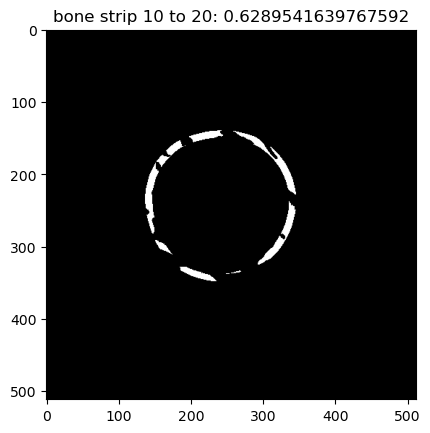

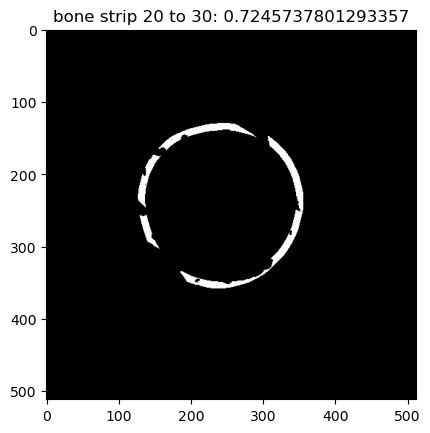

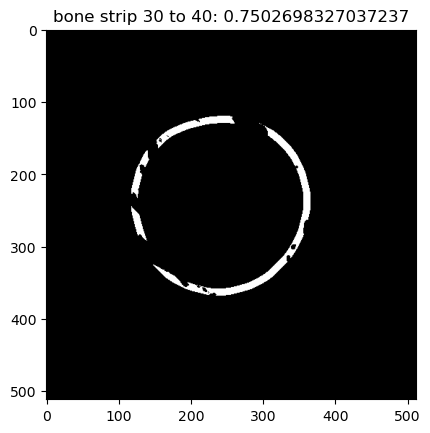

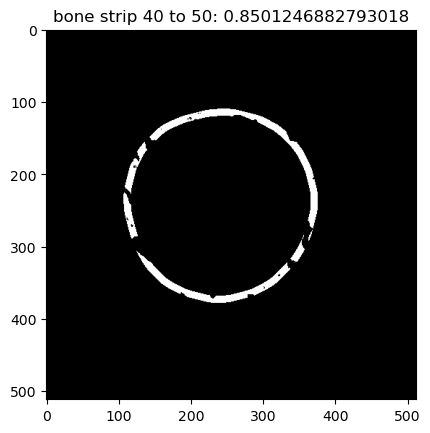

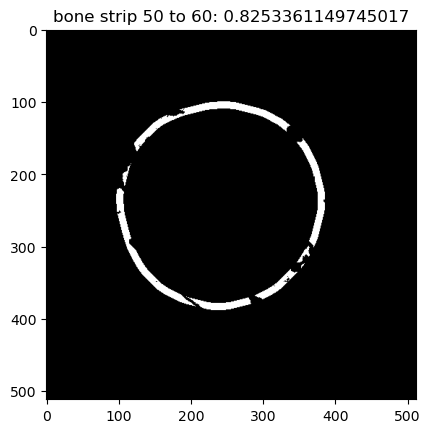

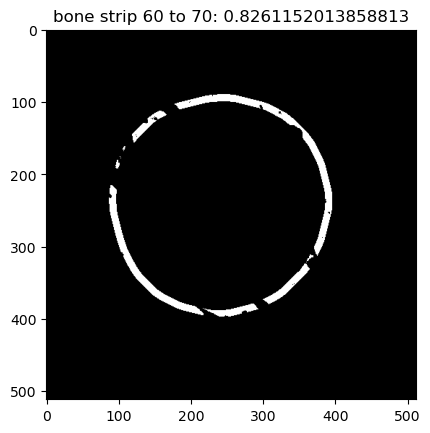

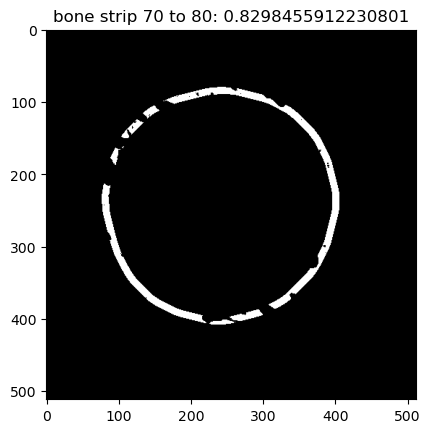

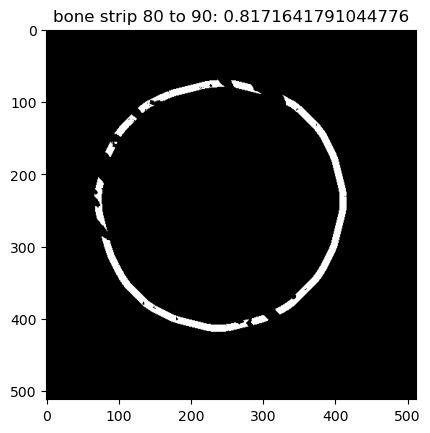

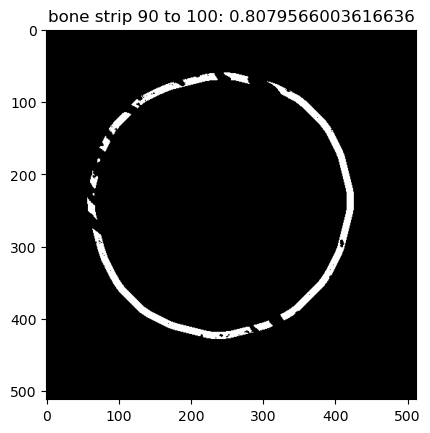

Text(0.5, 1.0, 'Bone fraction by distance to implant')

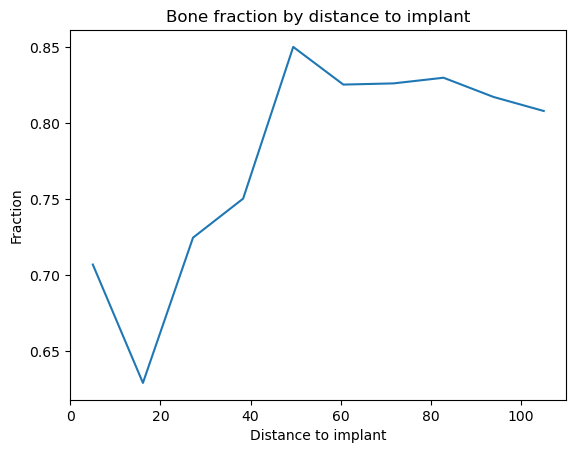

In [7]:
dskRadius = 10
dskelm = morphology.disk(dskRadius)
noSteps = int(100/dskRadius) # Convert to integer
boneFraction = np.zeros(noSteps)
hull = morphology.convex_hull_image(impltFiltLabels==1)
for i in range(noSteps):
    hullNext = morphology.binary_dilation(hull, dskelm)
    hullDiff = np.logical_and(hullNext, np.logical_not(hull))
    hull = hullNext
    boneSlice = hullDiff*boneFilt
    boneFraction[i] = float(boneSlice.sum())/float(hullDiff.sum()) # Note conversion to float!!!!
    plt.imshow(boneSlice)
    plt.title("bone strip "+str(i*dskRadius)+" to "+str((i+1)*dskRadius)+": "+str(boneFraction[i]))
    plt.show()
xCenter = np.linspace(dskRadius,dskRadius*(noSteps+1),len(boneFraction))-dskRadius/2
plt.plot(xCenter,boneFraction)
plt.xlabel('Distance to implant')
plt.ylabel('Fraction')
plt.title('Bone fraction by distance to implant')

**Assigment 2c:** Repeat the above with thinner strips and thicker strips and plot the bone fraction graph. What is the thinnest and thickest possible? What is the consequences of varying the strip thickness?